# Time Series Modeling - Sunspot Activity

#### Introduction
This project involves the analysis and forecasting of sunspot data using machine learning techniques, particularly Recurrent Neural Networks (RNN) and SARIMA models. The dataset spans from 1749 to 2019, detailing monthly mean total sunspot numbers.


#### Libraries and Dependencies
The following libraries are used in this project:
- Pandas
- NumPy
- CSV
- TensorFlow
- Matplotlib
- Scikit-learn
- Statsmodels

### Reading and Preparing the CSV Data

We start with importing required libraries.

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset
file_path = r'Sunspots.csv'

sunspot_data = pd.read_csv(file_path)

Datetime Conversion: The Date column is converted to datetime format for easier manipulation.

In [ ]:
# Convert the 'Date' column to datetime format
sunspot_data['Date'] = pd.to_datetime(sunspot_data['Date'])

In [ ]:
# Set the 'Date' column as the index
sunspot_data.set_index('Date', inplace=True)

In [ ]:
# Drop the original index column
sunspot_data.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# Check for missing values
missing_values = sunspot_data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Monthly Mean Total Sunspot Number    0
dtype: int64


Since the dataset does not include any missing values, we can directly begin with applying models after visualizing the time series graph.

In [ ]:
sunspot_data.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


We are going to observe the cycles in terms of collective months instead of years. Therefore, we arrange the dataset so that the x-axis shows total collective months.

In [ ]:
# Initialize lists for time steps and sunspots
time_step = []
sunspots = []

# Read the CSV file
try:
    with open(file_path) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)  # Skip the header
        for row in reader:
            date = pd.to_datetime(row[1])  # Assuming date is in the second column
            month_count = (date.year - 1749) * 12 + date.month  # Calculate month count since January 1749
            sunspots.append(float(row[2]))  # Assuming sunspot value is in the third column
            time_step.append(month_count)
    print("Dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check the file path and try again.")
    exit()

Dataset loaded successfully.


In [ ]:
sunspot_data.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


### Visualization


The sunspot data is visualized to understand the trends over time.

In [ ]:
# Function to plot the time series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.figure(figsize=(12, 6))
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time (Months)")
    plt.ylabel("Average Monthly Sunspots")
    if label:
        plt.legend()
    plt.grid(True)
    plt.show()

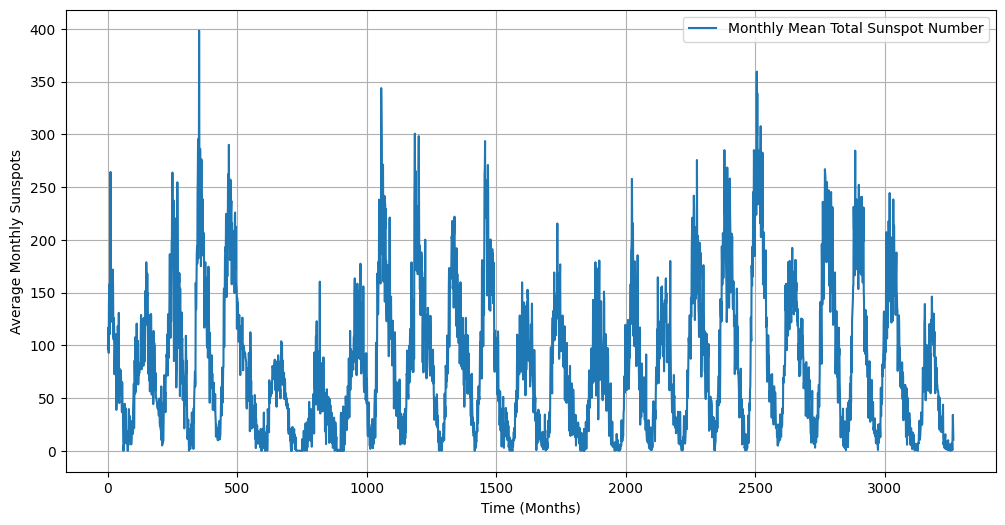

In [ ]:
# Plot the complete time series data in terms of months
plot_series(time_step, sunspots, label="Monthly Mean Total Sunspot Number")

### Pre-Processing

It is necessary to split the dataset into training and validation sets before applying any models for forecasting.

In [ ]:
# Split the data into training (80%) and validation (20%) sets
split_ratio = 0.8
split_index = int(len(time_step) * split_ratio)

In [ ]:
# Training data
train_time = time_step[:split_index]
train_sunspots = sunspots[:split_index]

In [ ]:
# Validation data
val_time = time_step[split_index:]
val_sunspots = sunspots[split_index:]

Let's observe the training and validation sets visually on the time series plot.

In [ ]:
# Function to plot the training and validation data separation
def plot_train_val_split(train_time, train_sunspots, val_time, val_sunspots):
    plt.figure(figsize=(12, 6))
    plt.plot(train_time, train_sunspots, label='Training Data')
    plt.plot(val_time, val_sunspots, label='Validation Data')
    plt.xlabel("Time (Months)")
    plt.ylabel("Average Monthly Sunspots")
    plt.title("Training and Validation Data Separation")
    plt.legend()
    plt.grid(True)
    plt.show()

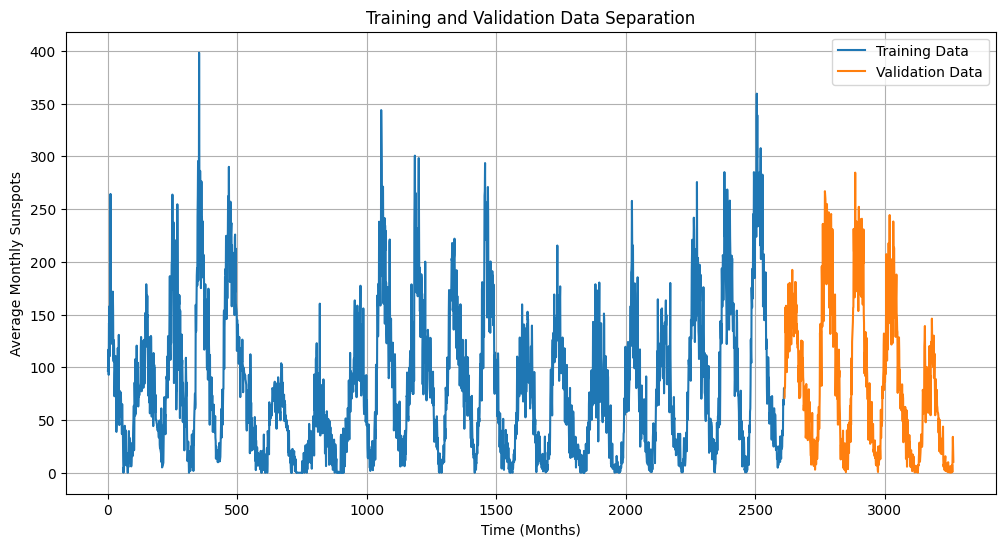

In [ ]:
# Plot the training and validation data separation
plot_train_val_split(train_time, train_sunspots, val_time, val_sunspots)

#### Windowing the dataset

We use a window size of 64 to create the sequences for our models.

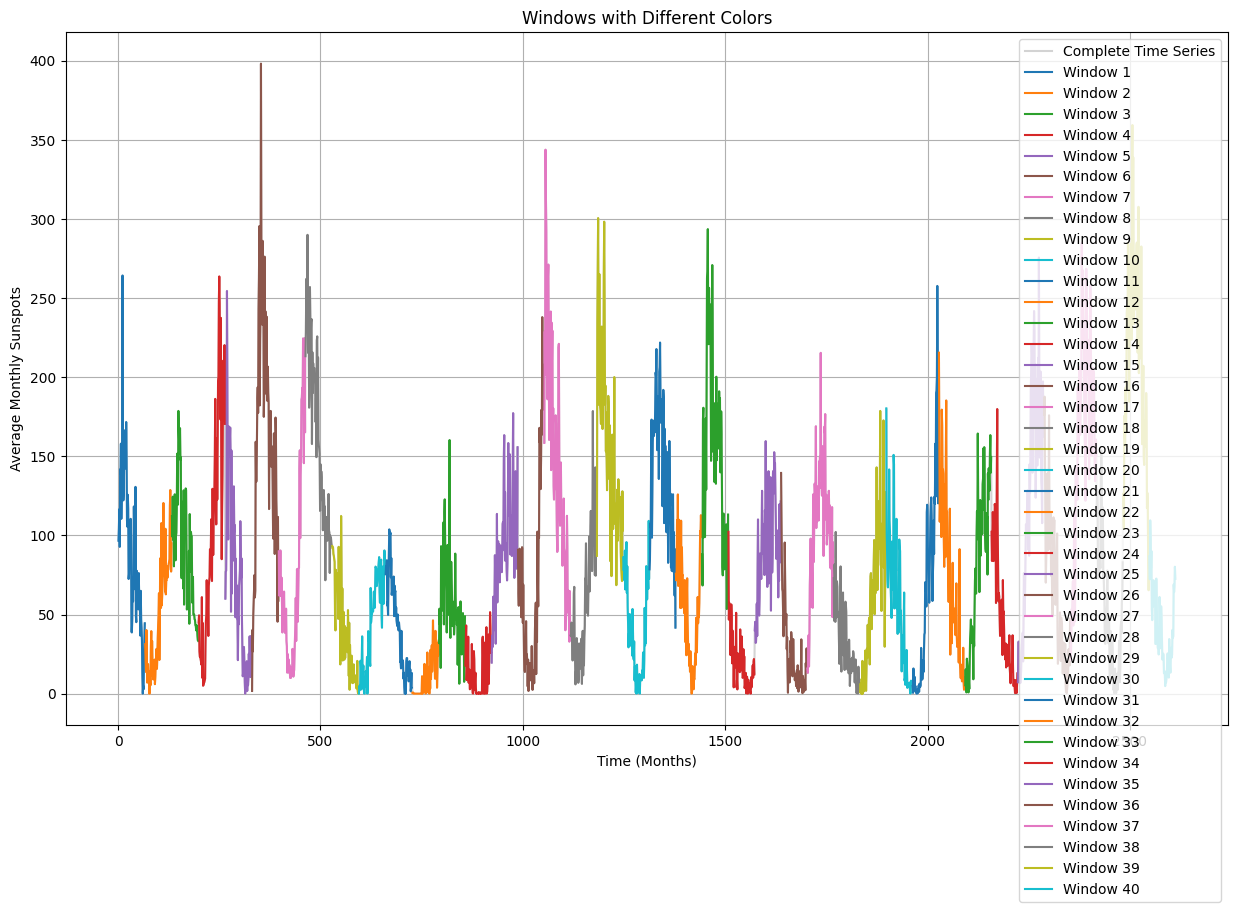

In [ ]:
# Plot the windows with different colors

window_size = 64

def plot_split(array, window_size):
    number_windows = len(array) // window_size
    return np.array_split(array, number_windows, axis=0)

plt.figure(figsize=(15, 9))
plt.title("Windows with Different Colors")

# Plot the complete time series data in the background
plt.plot(train_time, train_sunspots, color='lightgrey', label='Complete Time Series')

# Plot each window with a different color
for i, (series_window, time_window) in enumerate(zip(plot_split(train_sunspots, window_size), plot_split(train_time, window_size))):
    plt.plot(time_window, series_window, label=f'Window {i+1}')

plt.xlabel("Time (Months)")
plt.ylabel("Average Monthly Sunspots")
plt.legend()
plt.grid(True)
plt.show()

### Check for the Stationarity

Before applying any forecasting methods, one has to be sure that the time series is stationary. We check for the stationarity of our dataset with both ADF and KPSS tests.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

In [ ]:
# Function to perform KPSS test
def kpss_test(series):
    result = kpss(series, regression='c', nlags="auto")
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[3].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

In [ ]:
# Perform the tests on the training data
print("ADF Test on Training Data:")
adf_test(train_sunspots)

print("\nKPSS Test on Training Data:")
kpss_test(train_sunspots)

ADF Test on Training Data:
ADF Statistic: -9.130244724397873
p-value: 3.0357748379352445e-15
Critical Values:
   1%, -3.4328822265006687
Critical Values:
   5%, -2.862658740388024
Critical Values:
   10%, -2.5673655460943023

KPSS Test on Training Data:
KPSS Statistic: 0.10862617085439052
p-value: 0.1
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


If we consider the ADF test result, the p-value is very small (3.0357748379352445e-15), which is far below the common significance levels (0.01, 0.05, 0.10). This suggests that we can reject the null hypothesis of the ADF test, indicating that the series is stationary.

For the KPSS test, the p-value is 0.1, suggesting that we fail to reject the null hypothesis. This also indicates that the series is stationary.

### ARMA Model

Use the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to help determine the values for p (AR order) and q (MA order).

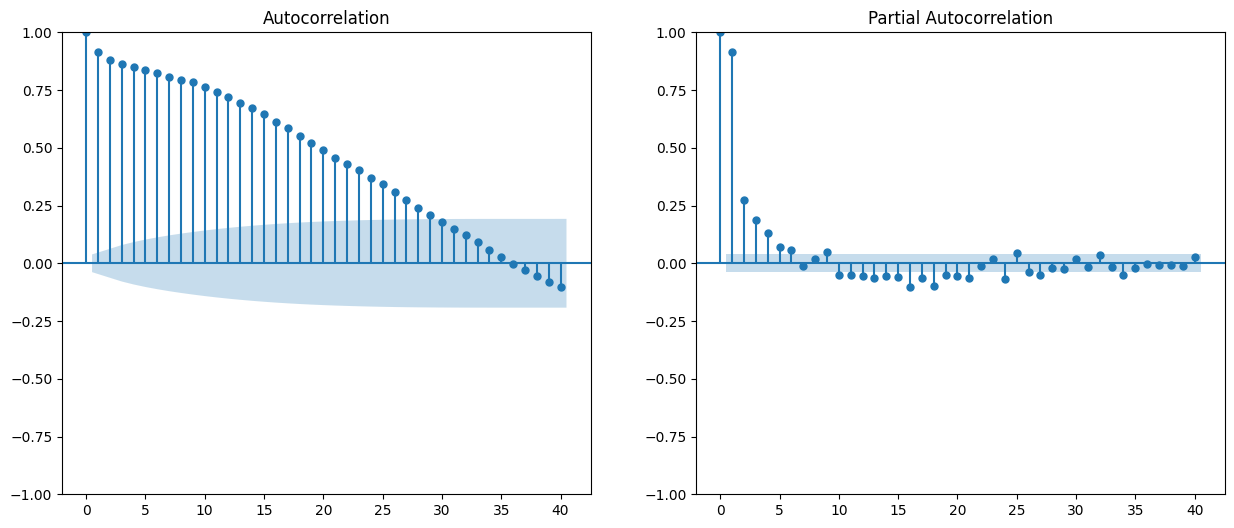

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 6))
plt.subplot(121)
plot_acf(train_sunspots, ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(train_sunspots, ax=plt.gca(), lags=40)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the order (p, d, q) based on ACF and PACF plots
p, d, q = 1, 0, 2  # Initial values based on the plots

In [ ]:
# Fit the ARMA model (ARIMA with d=0)
arma_model = ARIMA(train_sunspots, order=(p, d, q)).fit()

In [ ]:
# Forecast the validation period
forecast = arma_model.forecast(steps=len(val_sunspots))

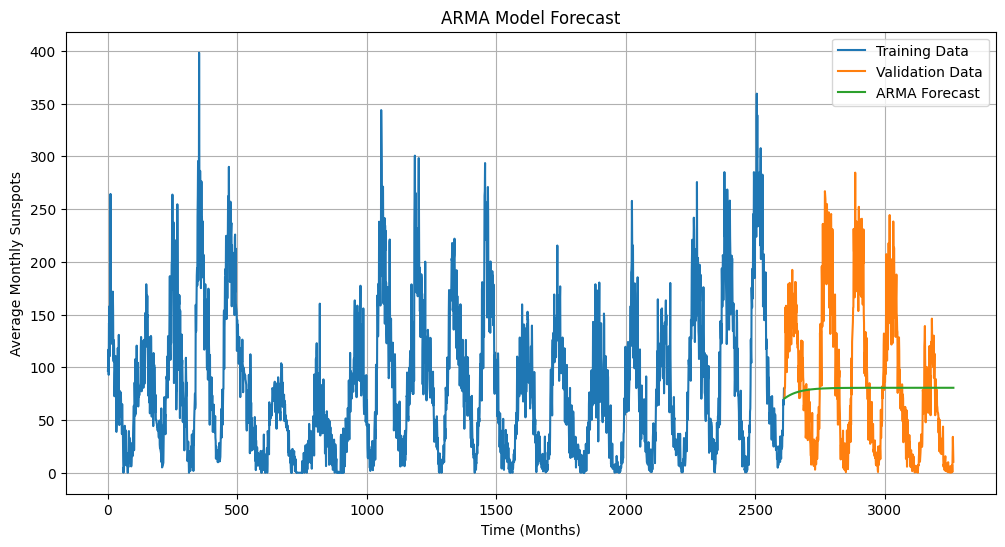

In [ ]:
# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_time, train_sunspots, label='Training Data')
plt.plot(val_time, val_sunspots, label='Validation Data')
plt.plot(val_time, forecast, label='ARMA Forecast')
plt.xlabel("Time (Months)")
plt.ylabel("Average Monthly Sunspots")
plt.title("ARMA Model Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate error metrics
mse = mean_squared_error(val_sunspots, forecast)
mae = mean_absolute_error(val_sunspots, forecast)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 4901.649691940907
Mean Absolute Error: 58.74762237660492


Obviously ARIMA model does not work well in our case. Since we have clear seasonal patterns, it would be definitely better if we try SARIMA instead of ARIMA.

### SARIMA Model

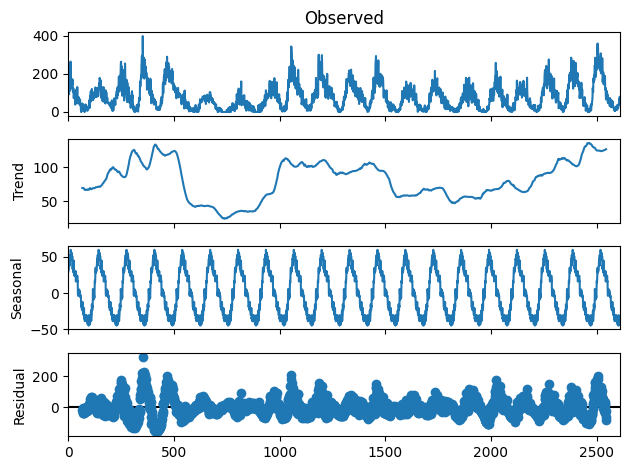

In [ ]:
#Identify Seasonal Parameters
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
result = seasonal_decompose(train_sunspots, model='additive', period=132)
result.plot()
plt.show()

Fit the SARIMA Model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the order and seasonal order
p, d, q = 1, 0, 1  # Adjust based on ACF and PACF plots
P, D, Q, S = 1, 1, 1, 132  # 11-year cycle for monthly data

In [ ]:
# Fit the SARIMA model
sarima_model = SARIMAX(train_sunspots, order=(p, d, q), seasonal_order=(P, D, Q, S)).fit()

In [ ]:
# Forecast the validation period
forecast = sarima_model.forecast(steps=len(val_sunspots))

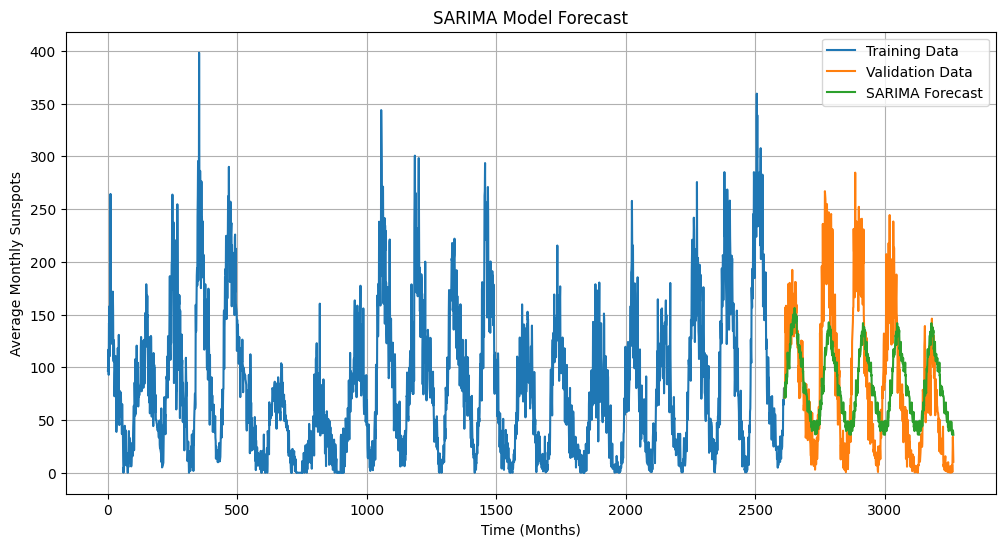

In [ ]:
# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train_time, train_sunspots, label='Training Data')
plt.plot(val_time, val_sunspots, label='Validation Data')
plt.plot(val_time, forecast, label='SARIMA Forecast')
plt.xlabel("Time (Months)")
plt.ylabel("Average Monthly Sunspots")
plt.title("SARIMA Model Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate error metrics
mse = mean_squared_error(val_sunspots, forecast)
mae = mean_absolute_error(val_sunspots, forecast)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3228.2975240650844
Mean Absolute Error: 45.088364857887136


## Recurrent Neural Networks
### Prepare the data for RNN

We already created sequences for the RNN model. It's also necessary to normalize the data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming train_sunspots and val_sunspots are lists, convert them to numpy arrays
train_sunspots = np.array(train_sunspots)
val_sunspots = np.array(val_sunspots)

# Function to create input-output pairs for the RNN
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_sunspots = scaler.fit_transform(train_sunspots.reshape(-1, 1))
val_sunspots = scaler.transform(val_sunspots.reshape(-1, 1))

In [ ]:
# Create sequences
X_train, y_train = create_sequences(train_sunspots, window_size)
X_val, y_val = create_sequences(val_sunspots, window_size)

# Reshape for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [ ]:
# Reshape for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

### Define the RNN Model

We define an RNN model using LSTM layers and a dense output layer. The model will be compiled with the Adam optimizer and mean squared error loss function. The model is trained on the training data and evaluated on the validation data.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the RNN model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50))
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

### Train the Model

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

In [ ]:
# Callbacks
callback = LearningRateScheduler(lr_scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[callback, early_stop])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0149 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0052 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0051 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0050 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0044 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0044 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0044 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0046 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0045 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 10/1

### Evaluate the Model

In [ ]:
# Evaluate the model on the validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Validation Loss: 0.0031691784970462322


### Make Predictions and Visualize

Now, it's time to predict the trained RNN model. Later, the predictions should be rescaled back to the original scale and plotted against the actual sunspot numbers to visually compare the performance of the model.

In [ ]:
# Make predictions
predictions = model.predict(X_val)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
# Rescale the predictions back to original scale
predictions = scaler.inverse_transform(predictions)
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))

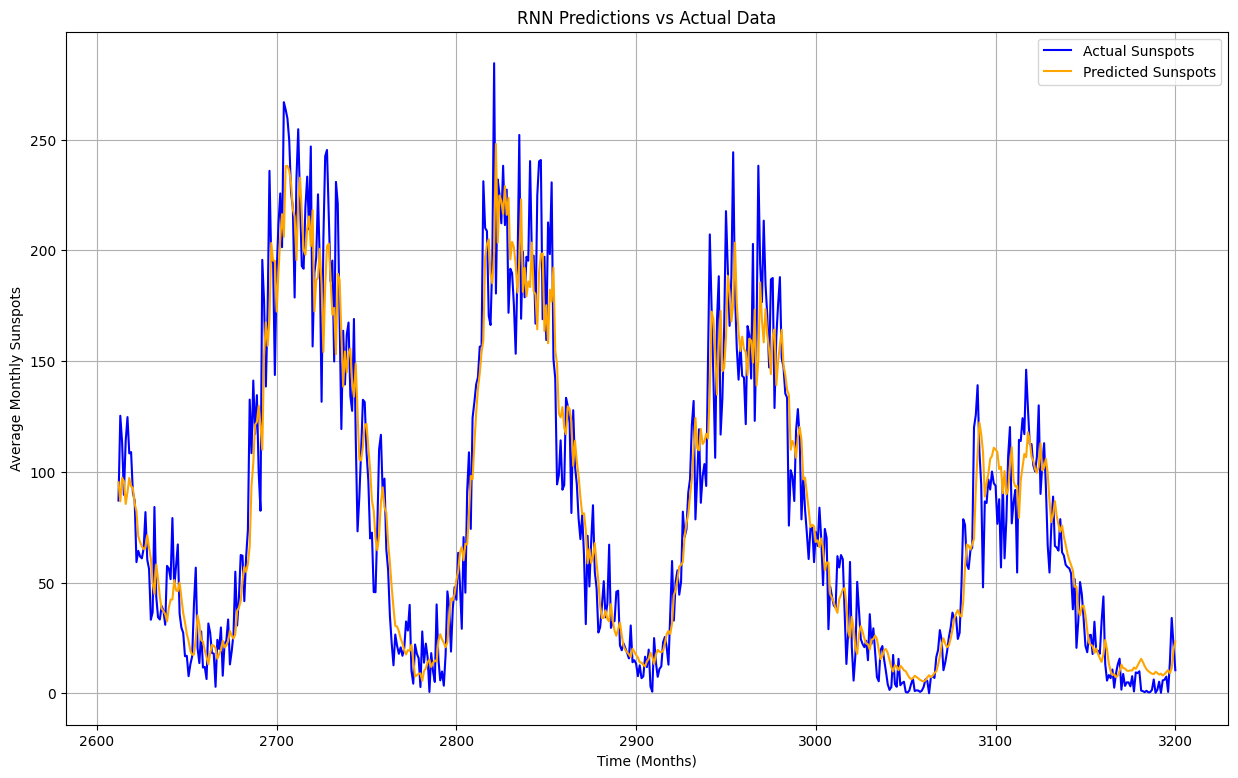

In [ ]:
# Plot the predictions against the actual values
plt.figure(figsize=(15, 9))
plt.plot(range(len(train_sunspots), len(train_sunspots) + len(y_val_rescaled)), y_val_rescaled, color='blue', label='Actual Sunspots')
plt.plot(range(len(train_sunspots), len(train_sunspots) + len(predictions)), predictions, color='orange', label='Predicted Sunspots')
plt.xlabel('Time (Months)')
plt.ylabel('Average Monthly Sunspots')
plt.title('RNN Predictions vs Actual Data')
plt.legend()
plt.grid(True)
plt.show()